In [ ]:
from xai.record import Recorder

with Recorder("output.mp4") as recorder:
    for i in range(60*5):
        recorder(np.full((1080,1920,3), 128, dtype=np.uint8))

In [ ]:
from xai.policy import Policy

Policy(100,10)

In [1]:
from xai.policy import Policy
import torch

p = Policy(3,10)
y = p(torch.tensor([
    [2.0,3.0,4.0],
    [2.0,3.0,4.0]
    ]))
y, y.greedy_max(), y.greedy_min().tuple(),

(tensor([[-0.2220, -0.2999,  0.4209,  0.0703, -0.1009,  0.3511, -0.2774, -0.0972,
          -0.1127,  0.2718],
         [-0.2220, -0.2999,  0.4209,  0.0703, -0.1009,  0.3511, -0.2774, -0.0972,
          -0.1127,  0.2718]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([2, 2], device='cuda:0'),
 (1, 1))

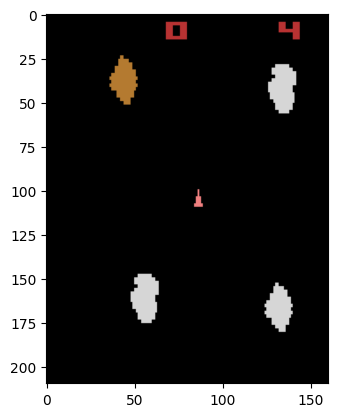

In [4]:
from xai.asteroids import Asteroids, Action
from PIL import Image
env = Asteroids()

env.step(Action.NOOP).observation.show("gray")

In [1]:
from ale_py import ALEInterface
from ale_py.roms import Asteroids
from ale_py import LoggerMode

import ale_py

ale_py.ALEInterface.setLoggerMode(LoggerMode.Error)
emulator: ALEInterface = ALEInterface()
emulator.loadROM(Asteroids)

In [ ]:
x = torch.tensor([[1.0,1.0],
                  [1.0,1.0]], requires_grad=True)

y = torch.tensor([[2.0,2.0],
                  [2.0,2.0]], requires_grad=True)



z = (x*y)

torch.autograd.grad(outputs=z[:,0], inputs=x, retain_graph=True)

In [ ]:
choices = z[:,:]
torch.autograd.grad(
    outputs=choices,
    inputs=x,
    grad_outputs=torch.ones_like(choices),
    retain_graph=True
)

In [ ]:
torch.autograd.grad(outputs=[z[0,0], z[1,1]], inputs=[x,y])

In [ ]:
torch.tensor([1.0]).dim()

In [ ]:
y.greedy_max()